<a href="https://colab.research.google.com/github/tanvigunjal/Pactice-ML/blob/main/ResNet_ImageClassification_CIFAR-10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Libraries

import torch
import torchvision
from torchvision import datasets,transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import numpy as np 
import matplotlib.pyplot as plt 
import torch.optim as optim
from torch.utils.data import random_split

#Check device (cuda or CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [2]:
# add transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

#Load he dataset 
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
#validation set 
valset_size = 5000
train_size = len(trainset) - valset_size

train_ds, val_ds = random_split(trainset, [train_size, valset_size])
print(len(train_ds))
print(len(val_ds))
print(len(testset))

# Dataloaders
trainloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


#image classes 
num_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

45000
5000
10000


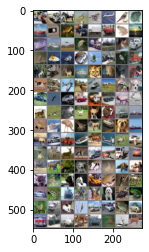

horse truck horse bird  bird  plane bird  frog  ship  cat   frog  car   truck car   frog  bird  ship  ship  plane bird  truck car   cat   car   bird  ship  ship  car   bird  dog   bird  truck frog  dog   deer  ship  cat   dog   bird  dog   cat   frog  plane deer  ship  horse frog  dog   car   bird  car   car   truck car   deer  deer  horse bird  frog  horse dog   cat   car   ship  frog  ship  bird  frog  horse car   dog   ship  deer  car   truck ship  horse ship  bird  plane dog   cat   deer  horse car   plane truck car   deer  horse bird  dog   dog   cat   cat   horse cat   deer  dog   horse car   frog  bird  horse car   frog  ship  bird  cat   dog   bird  frog  bird  ship  cat   bird  car   car   frog  car   truck truck plane dog   truck deer  ship  horse


In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{num_classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
#define ResNet architecture 
class block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(
            out_channels,
            out_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False
        )
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], out_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], out_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], out_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], out_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, out_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != out_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    out_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(out_channels * 4),
            )

        layers.append(
            block(self.in_channels, out_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = out_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)


def ResNet50(img_channel=3, num_classes=10):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)


In [6]:
# model
model = ResNet50(img_channel=3, num_classes=10).to(device)

#hyperparameters 
learning_rate = 0.001

# define optimizer 
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, min_lr=0)

#define loss
criterion = nn.CrossEntropyLoss()

In [7]:
#traning and validation loop 
epochs = 50
best_valid = np.Inf
train_loss_hist = []
train_acc_hist = []
val_loss_hist = []
val_acc_hist = [] 
for epoch in range(1, epochs+1):
      # Training Phase 
      model.train()
      correct = 0.0
      running_loss = 0.0
      for i, (inputs,labels) in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        # zero the parameter gradients
        optimizer.zero_grad()

        #calculate train accuracy 
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

      train_loss = running_loss / len(train_ds)
      train_acc = correct / len(train_ds)
      train_loss_hist.append(train_loss)
      train_acc_hist.append(train_acc)

      #Validation phase
      model.eval()
      with torch.no_grad():
        validation_correct = 0.0
        val_running_loss = 0.0
        for i, (inputs,labels) in enumerate(valloader):
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          loss = criterion(outputs, labels)

          #calculate validation accuracy 
          _, predicted = torch.max(outputs, 1)
          validation_correct += (predicted == labels).sum().item()
          val_running_loss += loss.item()

        val_loss = val_running_loss / len(val_ds)
        val_acc = correct / len(val_ds)
        val_loss_hist.append(val_loss)
        val_acc_hist.append(val_acc)

      print('[epoch %d] loss: %.5f accuracy: %.4f val loss: %.5f val accuracy: %.4f' % (epoch + 1, train_loss, train_acc, val_loss, val_acc))

      # Early Stopping
      if val_loss > best_valid:
        best_valid = val_loss
        # At this point also save a snapshot of the current model   
        torch.save(model.state_dict(), 'model_cifar.pt')   

[epoch 2] loss: 0.02092 accuracy: 0.2086 val loss: 0.02066 val accuracy: 1.8778
[epoch 3] loss: 0.01449 accuracy: 0.3192 val loss: 0.01343 val accuracy: 2.8728
[epoch 4] loss: 0.01199 accuracy: 0.4339 val loss: 0.01152 val accuracy: 3.9052
[epoch 5] loss: 0.01102 accuracy: 0.4906 val loss: 0.01042 val accuracy: 4.4150
[epoch 6] loss: 0.00958 accuracy: 0.5592 val loss: 0.00967 val accuracy: 5.0326
[epoch 7] loss: 0.00874 accuracy: 0.5983 val loss: 0.00891 val accuracy: 5.3848
[epoch 8] loss: 0.00785 accuracy: 0.6460 val loss: 0.00793 val accuracy: 5.8138
[epoch 9] loss: 0.00703 accuracy: 0.6817 val loss: 0.01276 val accuracy: 6.1354
[epoch 10] loss: 0.00745 accuracy: 0.6621 val loss: 0.00716 val accuracy: 5.9590
[epoch 11] loss: 0.00604 accuracy: 0.7279 val loss: 0.00729 val accuracy: 6.5514
[epoch 12] loss: 0.00539 accuracy: 0.7586 val loss: 0.00658 val accuracy: 6.8274
[epoch 13] loss: 0.00551 accuracy: 0.7529 val loss: 0.00619 val accuracy: 6.7758
[epoch 14] loss: 0.00471 accuracy: 0

In [3]:
legend = ['Train', 'Validation']
plt.plot(train_loss_hist)
plt.plot(val_loss_hist)
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(legend, loc='upper left')
plt.show()


In [9]:
#test the model 
model.eval()
pred = []
with torch.no_grad():
  correct = 0.0
  for i, (inputs,labels) in enumerate(testloader):
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          loss = criterion(outputs, labels)

          _, predicted = torch.max(outputs, 1)
          correct += (predicted == labels).sum().item()
          pred.append(predicted)
  pred = torch.cat(pred)

print('Accuracy on the 10000 test images: %.2f %%' % (100 * correct / len(testset)))

Accuracy on the 10000 test images: 74.85 %
